# Training with ResNet

In [1]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/My Drive/ANDL/Homework_1

Mounted at /gdrive
/gdrive/My Drive/ANDL/Homework_1


#Imports

In [2]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


#Loading data & folder Exploring

In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [4]:
# Dataset folders 
dataset_dir = 'atMost700'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8']


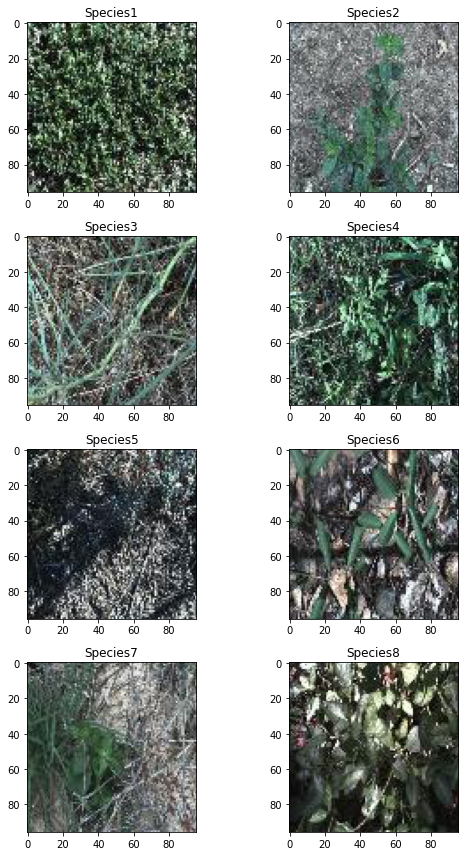

In [5]:
# Plot example images from dataset

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,6*num_col))

for i in range(num_row*num_col):
  if i < 21:
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))
    class_imgs = class_imgs[2]
    
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()


#Data Generator

Import:

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [12]:
# Create an instance of ImageDataGenerator with Data Augmentation
noaug_train_data_gen = ImageDataGenerator(
                                          height_shift_range=5, 
                                          width_shift_range=5, 
                                          
                                          horizontal_flip=True, 
                                          vertical_flip=True, 
                                          preprocessing_function=preprocess_input)
valid_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
noaug_train_gen = noaug_train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(96, 96),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96, 96),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=32,
                                               shuffle=False,
                                               seed=seed)

test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                               target_size=(96, 96),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=32,
                                               shuffle=False,
                                               seed=seed)


Found 5600 images belonging to 8 classes.
Found 527 images belonging to 8 classes.
Found 361 images belonging to 8 classes.


#Characteristics

In [8]:
input_shape = (96, 96, 3)
epochs = 200

#Declaring Network

In [9]:
# Model used:
# Layout
def build_model(input_shape):

  supernet = ResNet50(input_shape=(96, 96, 3),weights='imagenet', include_top=False)
  # supernet.trainable = False

  input_layer = tfkl.Input(shape=input_shape, name='Input')
  x = supernet(input_layer)
  x = tfkl.Flatten(name='Flattening')(x)
  x = tfkl.Dropout(0.3, seed=seed)(x)  
  output_layer = tfkl.Dense(
      8, 
      activation='softmax',
      kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


  model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

  # Compile the model
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.001), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


  return model


In [10]:
model = build_model(input_shape=input_shape)
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 Flattening (Flatten)        (None, 18432)             0         
                                                                 
 dropout (Dropout)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 8)                 147464    
                                                                 
Total params: 23,735,176
Trainable params: 23,682,056
Non-trainable params: 53,120
_____________________________________________

# Save checkpoints

In [13]:
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('../gdrive/MyDrive/ANDL/Homework_1/ResNetTest/Checkpts/Check') #this is the directory in which will be saved all checkpoints of LucaA of all experiments
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now)) #here will be saved the checkpoints of this single experiment
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = [] #declare a list of empty callbacks

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts') #In the directory of the experiment will be created the directory ckpts
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

#Training the model

In [14]:
noaug_callbacks = create_folders_and_callbacks(model_name='resnet_checks')

# Create folders and callbacks and fit
# Train the model
history = model.fit(
    x = noaug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = noaug_callbacks,
).history

Epoch 1/200
175/175 [==============================] - ETA: 0s - loss: 3.0929 - accuracy: 0.4157 - precision: 0.5065 - recall: 0.2029

175/175 [==============================] - 697s 4s/step - loss: 3.0929 - accuracy: 0.4157 - precision: 0.5065 - recall: 0.2029 - val_loss: 71.4146 - val_accuracy: 0.0778 - val_precision: 0.0799 - val_recall: 0.0626
Epoch 2/200
175/175 [==============================] - ETA: 0s - loss: 2.2584 - accuracy: 0.4595 - precision: 0.5834 - recall: 0.2780

175/175 [==============================] - 63s 360ms/step - loss: 2.2584 - accuracy: 0.4595 - precision: 0.5834 - recall: 0.2780 - val_loss: 3.2818 - val_accuracy: 0.4478 - val_precision: 0.5204 - val_recall: 0.1935
Epoch 3/200
175/175 [==============================] - ETA: 0s - loss: 1.8932 - accuracy: 0.4968 - precision: 0.6223 - recall: 0.3289

175/175 [==============================] - 59s 338ms/step - loss: 1.8932 - accuracy: 0.4968 - precision: 0.6223 - recall: 0.3289 - val_loss: 2.3396 - val_accuracy: 0.3909 - val_precision: 0.5248 - val_recall: 0.2808
Epoch 4/200
175/175 [==============================] - ETA: 0s - loss: 1.9269 - accuracy: 0.4934 - precision: 0.6155 - recall: 0.3116

175/175 [==============================] - 56s 322ms/step - loss: 1.9269 - accuracy: 0.4934 - precision: 0.6155 - recall: 0.3116 - val_loss: 4.1867 - val_accuracy: 0.3548 - val_precision: 0.4154 - val_recall: 0.3169
Epoch 5/200
175/175 [==============================] - ETA: 0s - loss: 1.7710 - accuracy: 0.5334 - precision: 0.6382 - recall: 0.3702

175/175 [==============================] - 55s 317ms/step - loss: 1.7710 - accuracy: 0.5334 - precision: 0.6382 - recall: 0.3702 - val_loss: 388.7780 - val_accuracy: 0.1556 - val_precision: 0.1590 - val_recall: 0.1309
Epoch 6/200
175/175 [==============================] - ETA: 0s - loss: 1.9537 - accuracy: 0.5036 - precision: 0.6217 - recall: 0.3452

175/175 [==============================] - 55s 316ms/step - loss: 1.9537 - accuracy: 0.5036 - precision: 0.6217 - recall: 0.3452 - val_loss: 460.0987 - val_accuracy: 0.2713 - val_precision: 0.2782 - val_recall: 0.2296
Epoch 7/200
175/175 [==============================] - ETA: 0s - loss: 1.7335 - accuracy: 0.5589 - precision: 0.6675 - recall: 0.4091

175/175 [==============================] - 56s 321ms/step - loss: 1.7335 - accuracy: 0.5589 - precision: 0.6675 - recall: 0.4091 - val_loss: 221.8541 - val_accuracy: 0.1992 - val_precision: 0.2022 - val_recall: 0.1727
Epoch 8/200
175/175 [==============================] - ETA: 0s - loss: 1.6919 - accuracy: 0.5863 - precision: 0.6815 - recall: 0.4582

175/175 [==============================] - 56s 319ms/step - loss: 1.6919 - accuracy: 0.5863 - precision: 0.6815 - recall: 0.4582 - val_loss: 3.9684 - val_accuracy: 0.2581 - val_precision: 0.2692 - val_recall: 0.2258
Epoch 9/200
175/175 [==============================] - ETA: 0s - loss: 1.8555 - accuracy: 0.5264 - precision: 0.6545 - recall: 0.3420

175/175 [==============================] - 55s 317ms/step - loss: 1.8555 - accuracy: 0.5264 - precision: 0.6545 - recall: 0.3420 - val_loss: 557.9306 - val_accuracy: 0.2694 - val_precision: 0.2735 - val_recall: 0.1822
Epoch 10/200
175/175 [==============================] - ETA: 0s - loss: 1.6752 - accuracy: 0.5562 - precision: 0.6607 - recall: 0.4093

175/175 [==============================] - 54s 309ms/step - loss: 1.6752 - accuracy: 0.5562 - precision: 0.6607 - recall: 0.4093 - val_loss: 12.8398 - val_accuracy: 0.2676 - val_precision: 0.3156 - val_recall: 0.1689
Epoch 11/200
175/175 [==============================] - ETA: 0s - loss: 1.5933 - accuracy: 0.5707 - precision: 0.6884 - recall: 0.4068

175/175 [==============================] - 55s 314ms/step - loss: 1.5933 - accuracy: 0.5707 - precision: 0.6884 - recall: 0.4068 - val_loss: 2.7957 - val_accuracy: 0.1803 - val_precision: 0.1963 - val_recall: 0.0797
Epoch 12/200
175/175 [==============================] - ETA: 0s - loss: 1.6744 - accuracy: 0.5757 - precision: 0.6660 - recall: 0.4459

175/175 [==============================] - 55s 314ms/step - loss: 1.6744 - accuracy: 0.5757 - precision: 0.6660 - recall: 0.4459 - val_loss: 2.3250 - val_accuracy: 0.2808 - val_precision: 0.3522 - val_recall: 0.2239
Epoch 13/200
175/175 [==============================] - ETA: 0s - loss: 1.6738 - accuracy: 0.5779 - precision: 0.6753 - recall: 0.4412

175/175 [==============================] - 55s 315ms/step - loss: 1.6738 - accuracy: 0.5779 - precision: 0.6753 - recall: 0.4412 - val_loss: 3.9500 - val_accuracy: 0.1157 - val_precision: 0.1154 - val_recall: 0.0455
Epoch 14/200
175/175 [==============================] - ETA: 0s - loss: 1.5904 - accuracy: 0.5475 - precision: 0.6588 - recall: 0.4052

175/175 [==============================] - 54s 311ms/step - loss: 1.5904 - accuracy: 0.5475 - precision: 0.6588 - recall: 0.4052 - val_loss: 1.6576 - val_accuracy: 0.4744 - val_precision: 0.5636 - val_recall: 0.3529
Epoch 15/200
175/175 [==============================] - ETA: 0s - loss: 1.5704 - accuracy: 0.5423 - precision: 0.6526 - recall: 0.3750

175/175 [==============================] - 55s 313ms/step - loss: 1.5704 - accuracy: 0.5423 - precision: 0.6526 - recall: 0.3750 - val_loss: 14.3401 - val_accuracy: 0.1670 - val_precision: 0.1622 - val_recall: 0.1385
Epoch 16/200
175/175 [==============================] - ETA: 0s - loss: 1.4586 - accuracy: 0.5704 - precision: 0.6740 - recall: 0.4350

175/175 [==============================] - 54s 310ms/step - loss: 1.4586 - accuracy: 0.5704 - precision: 0.6740 - recall: 0.4350 - val_loss: 6.7848 - val_accuracy: 0.3700 - val_precision: 0.4194 - val_recall: 0.2865
Epoch 17/200
175/175 [==============================] - ETA: 0s - loss: 1.3029 - accuracy: 0.6241 - precision: 0.7040 - recall: 0.5223

175/175 [==============================] - 55s 313ms/step - loss: 1.3029 - accuracy: 0.6241 - precision: 0.7040 - recall: 0.5223 - val_loss: 1.1642 - val_accuracy: 0.6148 - val_precision: 0.6817 - val_recall: 0.5161
Epoch 18/200
175/175 [==============================] - ETA: 0s - loss: 1.2233 - accuracy: 0.6232 - precision: 0.7045 - recall: 0.5130

175/175 [==============================] - 54s 310ms/step - loss: 1.2233 - accuracy: 0.6232 - precision: 0.7045 - recall: 0.5130 - val_loss: 1.3764 - val_accuracy: 0.5939 - val_precision: 0.6769 - val_recall: 0.5009
Epoch 19/200
175/175 [==============================] - ETA: 0s - loss: 0.9752 - accuracy: 0.6777 - precision: 0.7502 - recall: 0.5930

175/175 [==============================] - 54s 312ms/step - loss: 0.9752 - accuracy: 0.6777 - precision: 0.7502 - recall: 0.5930 - val_loss: 1.0751 - val_accuracy: 0.6338 - val_precision: 0.6865 - val_recall: 0.5484
Epoch 20/200
175/175 [==============================] - ETA: 0s - loss: 0.9927 - accuracy: 0.6834 - precision: 0.7536 - recall: 0.6036

175/175 [==============================] - 55s 316ms/step - loss: 0.9927 - accuracy: 0.6834 - precision: 0.7536 - recall: 0.6036 - val_loss: 2.3367 - val_accuracy: 0.3852 - val_precision: 0.4194 - val_recall: 0.3359
Epoch 21/200
175/175 [==============================] - ETA: 0s - loss: 0.8919 - accuracy: 0.6996 - precision: 0.7718 - recall: 0.6137

175/175 [==============================] - 54s 310ms/step - loss: 0.8919 - accuracy: 0.6996 - precision: 0.7718 - recall: 0.6137 - val_loss: 1.3108 - val_accuracy: 0.6262 - val_precision: 0.6901 - val_recall: 0.5579
Epoch 22/200
175/175 [==============================] - ETA: 0s - loss: 0.9096 - accuracy: 0.7043 - precision: 0.7642 - recall: 0.6268

175/175 [==============================] - 54s 310ms/step - loss: 0.9096 - accuracy: 0.7043 - precision: 0.7642 - recall: 0.6268 - val_loss: 1.1811 - val_accuracy: 0.6205 - val_precision: 0.6635 - val_recall: 0.5313
Epoch 23/200
175/175 [==============================] - ETA: 0s - loss: 0.8331 - accuracy: 0.7311 - precision: 0.7823 - recall: 0.6745

175/175 [==============================] - 54s 311ms/step - loss: 0.8331 - accuracy: 0.7311 - precision: 0.7823 - recall: 0.6745 - val_loss: 1.1349 - val_accuracy: 0.6471 - val_precision: 0.6794 - val_recall: 0.6072
Epoch 24/200
175/175 [==============================] - ETA: 0s - loss: 0.8932 - accuracy: 0.7155 - precision: 0.7698 - recall: 0.6496

175/175 [==============================] - 54s 310ms/step - loss: 0.8932 - accuracy: 0.7155 - precision: 0.7698 - recall: 0.6496 - val_loss: 11.2254 - val_accuracy: 0.4915 - val_precision: 0.5083 - val_recall: 0.4630
Epoch 25/200
175/175 [==============================] - ETA: 0s - loss: 0.7869 - accuracy: 0.7500 - precision: 0.8002 - recall: 0.6986

175/175 [==============================] - 55s 314ms/step - loss: 0.7869 - accuracy: 0.7500 - precision: 0.8002 - recall: 0.6986 - val_loss: 1.4318 - val_accuracy: 0.5693 - val_precision: 0.6300 - val_recall: 0.5104
Epoch 26/200
175/175 [==============================] - ETA: 0s - loss: 0.7550 - accuracy: 0.7571 - precision: 0.8005 - recall: 0.7052

175/175 [==============================] - 55s 312ms/step - loss: 0.7550 - accuracy: 0.7571 - precision: 0.8005 - recall: 0.7052 - val_loss: 1.1460 - val_accuracy: 0.6262 - val_precision: 0.6762 - val_recall: 0.5825
Epoch 27/200
175/175 [==============================] - ETA: 0s - loss: 0.6585 - accuracy: 0.7786 - precision: 0.8213 - recall: 0.7352

175/175 [==============================] - 54s 308ms/step - loss: 0.6585 - accuracy: 0.7786 - precision: 0.8213 - recall: 0.7352 - val_loss: 1.3816 - val_accuracy: 0.6072 - val_precision: 0.6311 - val_recall: 0.5617
Epoch 28/200
175/175 [==============================] - ETA: 0s - loss: 0.6876 - accuracy: 0.7807 - precision: 0.8222 - recall: 0.7425

175/175 [==============================] - 58s 330ms/step - loss: 0.6876 - accuracy: 0.7807 - precision: 0.8222 - recall: 0.7425 - val_loss: 1.1334 - val_accuracy: 0.6565 - val_precision: 0.7063 - val_recall: 0.5977
Epoch 29/200
175/175 [==============================] - ETA: 0s - loss: 0.6136 - accuracy: 0.7984 - precision: 0.8335 - recall: 0.7618

175/175 [==============================] - 56s 320ms/step - loss: 0.6136 - accuracy: 0.7984 - precision: 0.8335 - recall: 0.7618 - val_loss: 1.5688 - val_accuracy: 0.5560 - val_precision: 0.6030 - val_recall: 0.5332
Epoch 30/200
175/175 [==============================] - ETA: 0s - loss: 0.5428 - accuracy: 0.8193 - precision: 0.8514 - recall: 0.7880

175/175 [==============================] - 54s 311ms/step - loss: 0.5428 - accuracy: 0.8193 - precision: 0.8514 - recall: 0.7880 - val_loss: 1.0017 - val_accuracy: 0.6736 - val_precision: 0.7202 - val_recall: 0.6300
Epoch 31/200
175/175 [==============================] - ETA: 0s - loss: 0.9986 - accuracy: 0.7179 - precision: 0.7698 - recall: 0.6662

175/175 [==============================] - 54s 310ms/step - loss: 0.9986 - accuracy: 0.7179 - precision: 0.7698 - recall: 0.6662 - val_loss: 2.3183 - val_accuracy: 0.4554 - val_precision: 0.5000 - val_recall: 0.4042
Epoch 32/200
175/175 [==============================] - ETA: 0s - loss: 0.7916 - accuracy: 0.7573 - precision: 0.7990 - recall: 0.7155

175/175 [==============================] - 55s 313ms/step - loss: 0.7916 - accuracy: 0.7573 - precision: 0.7990 - recall: 0.7155 - val_loss: 1.6931 - val_accuracy: 0.5920 - val_precision: 0.6422 - val_recall: 0.5655
Epoch 33/200
175/175 [==============================] - ETA: 0s - loss: 0.6195 - accuracy: 0.8059 - precision: 0.8384 - recall: 0.7670

175/175 [==============================] - 55s 313ms/step - loss: 0.6195 - accuracy: 0.8059 - precision: 0.8384 - recall: 0.7670 - val_loss: 1.0170 - val_accuracy: 0.6850 - val_precision: 0.7319 - val_recall: 0.6528
Epoch 34/200
175/175 [==============================] - ETA: 0s - loss: 0.7808 - accuracy: 0.7738 - precision: 0.8136 - recall: 0.7343

175/175 [==============================] - 54s 311ms/step - loss: 0.7808 - accuracy: 0.7738 - precision: 0.8136 - recall: 0.7343 - val_loss: 1.2664 - val_accuracy: 0.5939 - val_precision: 0.6171 - val_recall: 0.5351
Epoch 35/200
175/175 [==============================] - ETA: 0s - loss: 0.6407 - accuracy: 0.7986 - precision: 0.8344 - recall: 0.7621

175/175 [==============================] - 54s 312ms/step - loss: 0.6407 - accuracy: 0.7986 - precision: 0.8344 - recall: 0.7621 - val_loss: 3.3391 - val_accuracy: 0.6072 - val_precision: 0.6237 - val_recall: 0.5787
Epoch 36/200
175/175 [==============================] - ETA: 0s - loss: 0.6341 - accuracy: 0.8095 - precision: 0.8382 - recall: 0.7734

175/175 [==============================] - 54s 309ms/step - loss: 0.6341 - accuracy: 0.8095 - precision: 0.8382 - recall: 0.7734 - val_loss: 4.7625 - val_accuracy: 0.3074 - val_precision: 0.3255 - val_recall: 0.2884
Epoch 37/200
175/175 [==============================] - ETA: 0s - loss: 0.5961 - accuracy: 0.8105 - precision: 0.8402 - recall: 0.7846

175/175 [==============================] - 54s 310ms/step - loss: 0.5961 - accuracy: 0.8105 - precision: 0.8402 - recall: 0.7846 - val_loss: 1.0147 - val_accuracy: 0.6755 - val_precision: 0.7059 - val_recall: 0.6376
Epoch 38/200
175/175 [==============================] - ETA: 0s - loss: 0.6586 - accuracy: 0.7952 - precision: 0.8303 - recall: 0.7671

175/175 [==============================] - 54s 307ms/step - loss: 0.6586 - accuracy: 0.7952 - precision: 0.8303 - recall: 0.7671 - val_loss: 1.6114 - val_accuracy: 0.5370 - val_precision: 0.5675 - val_recall: 0.5028
Epoch 39/200
175/175 [==============================] - ETA: 0s - loss: 0.4597 - accuracy: 0.8480 - precision: 0.8749 - recall: 0.8241

175/175 [==============================] - 54s 309ms/step - loss: 0.4597 - accuracy: 0.8480 - precision: 0.8749 - recall: 0.8241 - val_loss: 1.0750 - val_accuracy: 0.7116 - val_precision: 0.7348 - val_recall: 0.6888
Epoch 40/200
175/175 [==============================] - ETA: 0s - loss: 0.4007 - accuracy: 0.8634 - precision: 0.8830 - recall: 0.8462

175/175 [==============================] - 54s 309ms/step - loss: 0.4007 - accuracy: 0.8634 - precision: 0.8830 - recall: 0.8462 - val_loss: 0.9109 - val_accuracy: 0.7457 - val_precision: 0.7719 - val_recall: 0.7192
Epoch 41/200
175/175 [==============================] - ETA: 0s - loss: 0.3923 - accuracy: 0.8668 - precision: 0.8855 - recall: 0.8509

175/175 [==============================] - 54s 312ms/step - loss: 0.3923 - accuracy: 0.8668 - precision: 0.8855 - recall: 0.8509 - val_loss: 1.7618 - val_accuracy: 0.5617 - val_precision: 0.5878 - val_recall: 0.5465
Epoch 42/200
175/175 [==============================] - ETA: 0s - loss: 0.3494 - accuracy: 0.8804 - precision: 0.8954 - recall: 0.8650

175/175 [==============================] - 54s 308ms/step - loss: 0.3494 - accuracy: 0.8804 - precision: 0.8954 - recall: 0.8650 - val_loss: 1.0545 - val_accuracy: 0.7097 - val_precision: 0.7413 - val_recall: 0.6907
Epoch 43/200
175/175 [==============================] - ETA: 0s - loss: 0.3075 - accuracy: 0.8938 - precision: 0.9095 - recall: 0.8807

175/175 [==============================] - 54s 308ms/step - loss: 0.3075 - accuracy: 0.8938 - precision: 0.9095 - recall: 0.8807 - val_loss: 1.0260 - val_accuracy: 0.7287 - val_precision: 0.7540 - val_recall: 0.7154
Epoch 44/200
175/175 [==============================] - ETA: 0s - loss: 0.3875 - accuracy: 0.8807 - precision: 0.8933 - recall: 0.8652

175/175 [==============================] - 54s 307ms/step - loss: 0.3875 - accuracy: 0.8807 - precision: 0.8933 - recall: 0.8652 - val_loss: 4.0578 - val_accuracy: 0.5408 - val_precision: 0.5744 - val_recall: 0.5199
Epoch 45/200
175/175 [==============================] - ETA: 0s - loss: 0.4368 - accuracy: 0.8587 - precision: 0.8792 - recall: 0.8413

175/175 [==============================] - 54s 309ms/step - loss: 0.4368 - accuracy: 0.8587 - precision: 0.8792 - recall: 0.8413 - val_loss: 1.5062 - val_accuracy: 0.6471 - val_precision: 0.6627 - val_recall: 0.6262
Epoch 46/200
175/175 [==============================] - ETA: 0s - loss: 0.3532 - accuracy: 0.8816 - precision: 0.9001 - recall: 0.8659

175/175 [==============================] - 54s 309ms/step - loss: 0.3532 - accuracy: 0.8816 - precision: 0.9001 - recall: 0.8659 - val_loss: 1.6195 - val_accuracy: 0.6053 - val_precision: 0.6398 - val_recall: 0.5863
Epoch 47/200
175/175 [==============================] - ETA: 0s - loss: 0.2974 - accuracy: 0.8964 - precision: 0.9075 - recall: 0.8852

175/175 [==============================] - 54s 307ms/step - loss: 0.2974 - accuracy: 0.8964 - precision: 0.9075 - recall: 0.8852 - val_loss: 3.8599 - val_accuracy: 0.3795 - val_precision: 0.3870 - val_recall: 0.3605
Epoch 48/200
175/175 [==============================] - ETA: 0s - loss: 0.2774 - accuracy: 0.9100 - precision: 0.9205 - recall: 0.8973

175/175 [==============================] - 54s 308ms/step - loss: 0.2774 - accuracy: 0.9100 - precision: 0.9205 - recall: 0.8973 - val_loss: 2.6666 - val_accuracy: 0.6034 - val_precision: 0.6165 - val_recall: 0.5825
Epoch 49/200
175/175 [==============================] - ETA: 0s - loss: 0.2950 - accuracy: 0.9030 - precision: 0.9144 - recall: 0.8932

175/175 [==============================] - 54s 307ms/step - loss: 0.2950 - accuracy: 0.9030 - precision: 0.9144 - recall: 0.8932 - val_loss: 1.3299 - val_accuracy: 0.6717 - val_precision: 0.6859 - val_recall: 0.6546
Epoch 50/200
175/175 [==============================] - ETA: 0s - loss: 0.3526 - accuracy: 0.8857 - precision: 0.9017 - recall: 0.8732

175/175 [==============================] - 54s 307ms/step - loss: 0.3526 - accuracy: 0.8857 - precision: 0.9017 - recall: 0.8732 - val_loss: 8.2700 - val_accuracy: 0.1499 - val_precision: 0.1487 - val_recall: 0.1442
Epoch 51/200
175/175 [==============================] - ETA: 0s - loss: 0.3755 - accuracy: 0.8788 - precision: 0.8949 - recall: 0.8680

175/175 [==============================] - 54s 308ms/step - loss: 0.3755 - accuracy: 0.8788 - precision: 0.8949 - recall: 0.8680 - val_loss: 1.3580 - val_accuracy: 0.6471 - val_precision: 0.6872 - val_recall: 0.6338
Epoch 52/200
175/175 [==============================] - ETA: 0s - loss: 0.2798 - accuracy: 0.9038 - precision: 0.9173 - recall: 0.8936

175/175 [==============================] - 54s 307ms/step - loss: 0.2798 - accuracy: 0.9038 - precision: 0.9173 - recall: 0.8936 - val_loss: 1.1734 - val_accuracy: 0.6755 - val_precision: 0.6850 - val_recall: 0.6395
Epoch 53/200
175/175 [==============================] - ETA: 0s - loss: 0.2702 - accuracy: 0.9134 - precision: 0.9222 - recall: 0.9055

175/175 [==============================] - 54s 311ms/step - loss: 0.2702 - accuracy: 0.9134 - precision: 0.9222 - recall: 0.9055 - val_loss: 1.0528 - val_accuracy: 0.7438 - val_precision: 0.7625 - val_recall: 0.7249
Epoch 54/200
175/175 [==============================] - ETA: 0s - loss: 0.3452 - accuracy: 0.8977 - precision: 0.9096 - recall: 0.8841

175/175 [==============================] - 54s 309ms/step - loss: 0.3452 - accuracy: 0.8977 - precision: 0.9096 - recall: 0.8841 - val_loss: 1.5541 - val_accuracy: 0.6717 - val_precision: 0.6948 - val_recall: 0.6565
Epoch 55/200
175/175 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.8943 - precision: 0.9062 - recall: 0.8813

175/175 [==============================] - 54s 309ms/step - loss: 0.3342 - accuracy: 0.8943 - precision: 0.9062 - recall: 0.8813 - val_loss: 1.2291 - val_accuracy: 0.7116 - val_precision: 0.7410 - val_recall: 0.7002


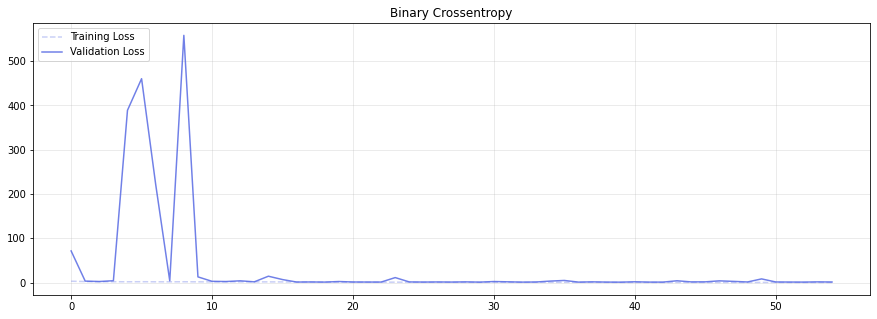

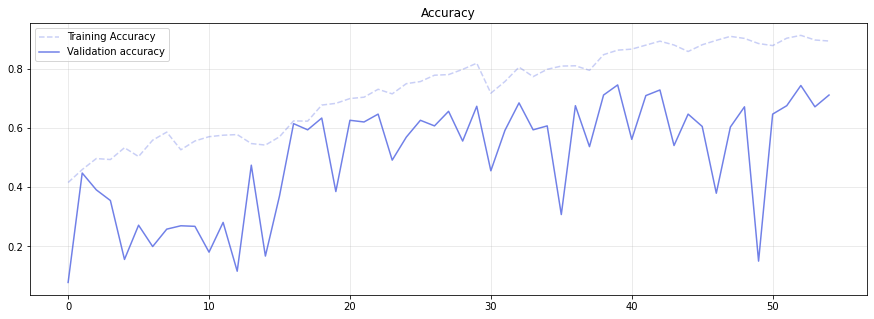

In [15]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Used to load checkpoints since we had problems with colab, then we re-started with the fit in teh above cell
#model.load_weights('../gdrive/MyDrive/Challenge1_Mio/ResNetTest/Checkpts/Check/resnet_checks_Nov21_13-49-42/ckpts/cp.ckpt')

In [16]:
%cd /gdrive/MyDrive/ANDL/Homework_1

/gdrive/My Drive/ANDL/Homework_1


In [17]:
# Save best epoch model
model.save("ResNetTest/Resnet_v1")

In [18]:
model = tfk.models.load_model("ResNetTest/Resnet_v1")

In [19]:
for i, layer in enumerate(model.get_layer('resnet50').layers):
   layer.trainable = False

for i, layer in enumerate(model.get_layer('resnet50').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [20]:
for i, layer in enumerate(model.get_layer('resnet50').layers[143:]):
   layer.trainable = True

for i, layer in enumerate(model.get_layer('resnet50').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 Flattening (Flatten)        (None, 18432)             0         
                                                                 
 dropout (Dropout)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 8)                 147464    
                                                                 
Total params: 23,735,176
Trainable params: 15,123,464
Non-trainable params: 8,611,712
_________________________________________________________________


In [22]:
noaug_callbacks = create_folders_and_callbacks(model_name='resnet_checks_fine_tuning')

# Create folders and callbacks and fit
# Train the model
history = model.fit(
    x = noaug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = noaug_callbacks,
).history

Epoch 1/200
175/175 [==============================] - ETA: 0s - loss: 0.5182 - accuracy: 0.8352 - precision: 0.8560 - recall: 0.8130

175/175 [==============================] - 60s 313ms/step - loss: 0.5182 - accuracy: 0.8352 - precision: 0.8560 - recall: 0.8130 - val_loss: 1.0985 - val_accuracy: 0.7400 - val_precision: 0.7545 - val_recall: 0.7230
Epoch 2/200
175/175 [==============================] - ETA: 0s - loss: 0.5297 - accuracy: 0.8366 - precision: 0.8605 - recall: 0.8139

175/175 [==============================] - 55s 314ms/step - loss: 0.5297 - accuracy: 0.8366 - precision: 0.8605 - recall: 0.8139 - val_loss: 2.0959 - val_accuracy: 0.6395 - val_precision: 0.6600 - val_recall: 0.6262
Epoch 3/200
175/175 [==============================] - ETA: 0s - loss: 0.4700 - accuracy: 0.8452 - precision: 0.8688 - recall: 0.8243

175/175 [==============================] - 55s 316ms/step - loss: 0.4700 - accuracy: 0.8452 - precision: 0.8688 - recall: 0.8243 - val_loss: 3.4492 - val_accuracy: 0.5560 - val_precision: 0.5680 - val_recall: 0.5389
Epoch 4/200
175/175 [==============================] - ETA: 0s - loss: 0.4484 - accuracy: 0.8571 - precision: 0.8806 - recall: 0.8391

175/175 [==============================] - 54s 311ms/step - loss: 0.4484 - accuracy: 0.8571 - precision: 0.8806 - recall: 0.8391 - val_loss: 1.6759 - val_accuracy: 0.5598 - val_precision: 0.5924 - val_recall: 0.5351
Epoch 5/200
175/175 [==============================] - ETA: 0s - loss: 0.5861 - accuracy: 0.8361 - precision: 0.8583 - recall: 0.8121

175/175 [==============================] - 55s 316ms/step - loss: 0.5861 - accuracy: 0.8361 - precision: 0.8583 - recall: 0.8121 - val_loss: 1.9859 - val_accuracy: 0.5522 - val_precision: 0.5855 - val_recall: 0.5066
Epoch 6/200
175/175 [==============================] - ETA: 0s - loss: 0.5696 - accuracy: 0.8414 - precision: 0.8647 - recall: 0.8182

175/175 [==============================] - 55s 314ms/step - loss: 0.5696 - accuracy: 0.8414 - precision: 0.8647 - recall: 0.8182 - val_loss: 403.6416 - val_accuracy: 0.3150 - val_precision: 0.3225 - val_recall: 0.3017
Epoch 7/200
175/175 [==============================] - ETA: 0s - loss: 0.8676 - accuracy: 0.8079 - precision: 0.8408 - recall: 0.7752

175/175 [==============================] - 56s 321ms/step - loss: 0.8676 - accuracy: 0.8079 - precision: 0.8408 - recall: 0.7752 - val_loss: 1.1027 - val_accuracy: 0.6888 - val_precision: 0.7308 - val_recall: 0.6698
Epoch 8/200
175/175 [==============================] - ETA: 0s - loss: 0.4873 - accuracy: 0.8596 - precision: 0.8804 - recall: 0.8416

175/175 [==============================] - 55s 316ms/step - loss: 0.4873 - accuracy: 0.8596 - precision: 0.8804 - recall: 0.8416 - val_loss: 1.0719 - val_accuracy: 0.6717 - val_precision: 0.6969 - val_recall: 0.6414
Epoch 9/200
175/175 [==============================] - ETA: 0s - loss: 0.3894 - accuracy: 0.8752 - precision: 0.8927 - recall: 0.8620

175/175 [==============================] - 55s 314ms/step - loss: 0.3894 - accuracy: 0.8752 - precision: 0.8927 - recall: 0.8620 - val_loss: 1.1749 - val_accuracy: 0.6528 - val_precision: 0.6707 - val_recall: 0.6376
Epoch 10/200
175/175 [==============================] - ETA: 0s - loss: 0.3182 - accuracy: 0.9000 - precision: 0.9114 - recall: 0.8888

175/175 [==============================] - 55s 312ms/step - loss: 0.3182 - accuracy: 0.9000 - precision: 0.9114 - recall: 0.8888 - val_loss: 1.8125 - val_accuracy: 0.6471 - val_precision: 0.6761 - val_recall: 0.6338
Epoch 11/200
175/175 [==============================] - ETA: 0s - loss: 0.3083 - accuracy: 0.8988 - precision: 0.9105 - recall: 0.8888

175/175 [==============================] - 56s 320ms/step - loss: 0.3083 - accuracy: 0.8988 - precision: 0.9105 - recall: 0.8888 - val_loss: 1.4562 - val_accuracy: 0.6357 - val_precision: 0.6653 - val_recall: 0.6148
Epoch 12/200
175/175 [==============================] - ETA: 0s - loss: 0.3012 - accuracy: 0.9021 - precision: 0.9135 - recall: 0.8898

175/175 [==============================] - 54s 308ms/step - loss: 0.3012 - accuracy: 0.9021 - precision: 0.9135 - recall: 0.8898 - val_loss: 1.5657 - val_accuracy: 0.6641 - val_precision: 0.6883 - val_recall: 0.6452
Epoch 13/200
175/175 [==============================] - ETA: 0s - loss: 0.3610 - accuracy: 0.8954 - precision: 0.9090 - recall: 0.8829

175/175 [==============================] - 56s 318ms/step - loss: 0.3610 - accuracy: 0.8954 - precision: 0.9090 - recall: 0.8829 - val_loss: 1.4481 - val_accuracy: 0.6793 - val_precision: 0.6984 - val_recall: 0.6546
Epoch 14/200
175/175 [==============================] - ETA: 0s - loss: 0.3422 - accuracy: 0.8995 - precision: 0.9101 - recall: 0.8875

175/175 [==============================] - 55s 314ms/step - loss: 0.3422 - accuracy: 0.8995 - precision: 0.9101 - recall: 0.8875 - val_loss: 0.9534 - val_accuracy: 0.7343 - val_precision: 0.7669 - val_recall: 0.7116
Epoch 15/200
175/175 [==============================] - ETA: 0s - loss: 0.2593 - accuracy: 0.9127 - precision: 0.9238 - recall: 0.9027

175/175 [==============================] - 55s 313ms/step - loss: 0.2593 - accuracy: 0.9127 - precision: 0.9238 - recall: 0.9027 - val_loss: 1.3342 - val_accuracy: 0.6888 - val_precision: 0.7123 - val_recall: 0.6717
Epoch 16/200
175/175 [==============================] - ETA: 0s - loss: 0.2723 - accuracy: 0.9145 - precision: 0.9251 - recall: 0.9062

175/175 [==============================] - 55s 313ms/step - loss: 0.2723 - accuracy: 0.9145 - precision: 0.9251 - recall: 0.9062 - val_loss: 3.5157 - val_accuracy: 0.5142 - val_precision: 0.5226 - val_recall: 0.5047
Epoch 17/200
175/175 [==============================] - ETA: 0s - loss: 0.2996 - accuracy: 0.9125 - precision: 0.9232 - recall: 0.9018

175/175 [==============================] - 55s 314ms/step - loss: 0.2996 - accuracy: 0.9125 - precision: 0.9232 - recall: 0.9018 - val_loss: 1.2415 - val_accuracy: 0.7021 - val_precision: 0.7226 - val_recall: 0.6869
Epoch 18/200
175/175 [==============================] - ETA: 0s - loss: 0.2842 - accuracy: 0.9098 - precision: 0.9182 - recall: 0.9036

175/175 [==============================] - 55s 313ms/step - loss: 0.2842 - accuracy: 0.9098 - precision: 0.9182 - recall: 0.9036 - val_loss: 7.0307 - val_accuracy: 0.6224 - val_precision: 0.6444 - val_recall: 0.6053
Epoch 19/200
175/175 [==============================] - ETA: 0s - loss: 0.2379 - accuracy: 0.9304 - precision: 0.9360 - recall: 0.9221

175/175 [==============================] - 55s 316ms/step - loss: 0.2379 - accuracy: 0.9304 - precision: 0.9360 - recall: 0.9221 - val_loss: 1.3104 - val_accuracy: 0.7324 - val_precision: 0.7520 - val_recall: 0.7249
Epoch 20/200
175/175 [==============================] - ETA: 0s - loss: 0.2355 - accuracy: 0.9300 - precision: 0.9373 - recall: 0.9234

175/175 [==============================] - 55s 316ms/step - loss: 0.2355 - accuracy: 0.9300 - precision: 0.9373 - recall: 0.9234 - val_loss: 1.0994 - val_accuracy: 0.7173 - val_precision: 0.7241 - val_recall: 0.7021
Epoch 21/200
175/175 [==============================] - ETA: 0s - loss: 0.2006 - accuracy: 0.9352 - precision: 0.9414 - recall: 0.9298

175/175 [==============================] - 55s 315ms/step - loss: 0.2006 - accuracy: 0.9352 - precision: 0.9414 - recall: 0.9298 - val_loss: 1.1223 - val_accuracy: 0.7059 - val_precision: 0.7230 - val_recall: 0.6983
Epoch 22/200
175/175 [==============================] - ETA: 0s - loss: 0.2151 - accuracy: 0.9311 - precision: 0.9378 - recall: 0.9241

175/175 [==============================] - 55s 317ms/step - loss: 0.2151 - accuracy: 0.9311 - precision: 0.9378 - recall: 0.9241 - val_loss: 3.3154 - val_accuracy: 0.4782 - val_precision: 0.4892 - val_recall: 0.4706
Epoch 23/200
175/175 [==============================] - ETA: 0s - loss: 0.2605 - accuracy: 0.9196 - precision: 0.9277 - recall: 0.9118

175/175 [==============================] - 55s 315ms/step - loss: 0.2605 - accuracy: 0.9196 - precision: 0.9277 - recall: 0.9118 - val_loss: 0.9659 - val_accuracy: 0.7628 - val_precision: 0.7776 - val_recall: 0.7495
Epoch 24/200
175/175 [==============================] - ETA: 0s - loss: 0.2320 - accuracy: 0.9266 - precision: 0.9335 - recall: 0.9200

175/175 [==============================] - 55s 317ms/step - loss: 0.2320 - accuracy: 0.9266 - precision: 0.9335 - recall: 0.9200 - val_loss: 2.5457 - val_accuracy: 0.6679 - val_precision: 0.6871 - val_recall: 0.6584
Epoch 25/200
175/175 [==============================] - ETA: 0s - loss: 0.1935 - accuracy: 0.9373 - precision: 0.9424 - recall: 0.9325

175/175 [==============================] - 55s 314ms/step - loss: 0.1935 - accuracy: 0.9373 - precision: 0.9424 - recall: 0.9325 - val_loss: 1.9365 - val_accuracy: 0.5939 - val_precision: 0.6072 - val_recall: 0.5750
Epoch 26/200
175/175 [==============================] - ETA: 0s - loss: 0.2745 - accuracy: 0.9202 - precision: 0.9273 - recall: 0.9136

175/175 [==============================] - 55s 312ms/step - loss: 0.2745 - accuracy: 0.9202 - precision: 0.9273 - recall: 0.9136 - val_loss: 1.2956 - val_accuracy: 0.7438 - val_precision: 0.7495 - val_recall: 0.7324
Epoch 27/200
175/175 [==============================] - ETA: 0s - loss: 0.2330 - accuracy: 0.9291 - precision: 0.9346 - recall: 0.9207

175/175 [==============================] - 55s 314ms/step - loss: 0.2330 - accuracy: 0.9291 - precision: 0.9346 - recall: 0.9207 - val_loss: 1.4285 - val_accuracy: 0.7514 - val_precision: 0.7677 - val_recall: 0.7400
Epoch 28/200
175/175 [==============================] - ETA: 0s - loss: 0.2210 - accuracy: 0.9346 - precision: 0.9399 - recall: 0.9295

175/175 [==============================] - 55s 315ms/step - loss: 0.2210 - accuracy: 0.9346 - precision: 0.9399 - recall: 0.9295 - val_loss: 1.9148 - val_accuracy: 0.5958 - val_precision: 0.6120 - val_recall: 0.5806
Epoch 29/200
175/175 [==============================] - ETA: 0s - loss: 0.2158 - accuracy: 0.9280 - precision: 0.9351 - recall: 0.9209

175/175 [==============================] - 55s 314ms/step - loss: 0.2158 - accuracy: 0.9280 - precision: 0.9351 - recall: 0.9209 - val_loss: 1.3844 - val_accuracy: 0.6831 - val_precision: 0.6963 - val_recall: 0.6698


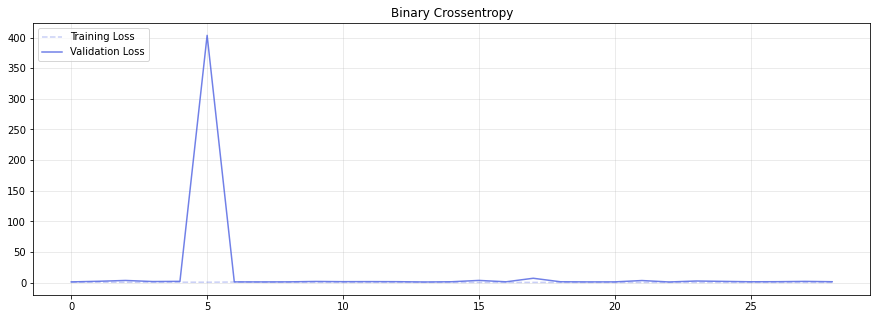

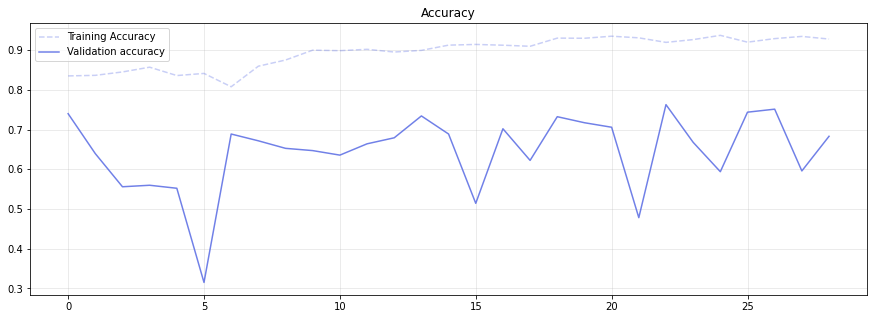

In [23]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [24]:
%cd /gdrive/MyDrive/ANDL/Homework_1

/gdrive/My Drive/ANDL/Homework_1


In [25]:
model.save("ResNetTest/Resnet_v1_t1")

#Show predictions
We evaluate the model looking at the test set predictions

In [26]:
model = tfk.models.load_model("ResNetTest/Resnet_v1_t1")

In [27]:
model_test_metrics = model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)

12/12 [==============================] - 43s 4s/step - loss: 1.0491 - accuracy: 0.7202 - precision: 0.7568 - recall: 0.6981

Test metrics
{'loss': 1.0490564107894897, 'accuracy': 0.7202215790748596, 'precision': 0.7567567825317383, 'recall': 0.698060929775238}


In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = model.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


Accuracy: 0.7202
Precision: 0.6958
Recall: 0.709
F1: 0.6963
